In [14]:
colors = {
    "p53": "#008DD5",
    "nutlin": "#DB5461",
    "nfkb": "#C33149",
    "tnf": "#107E7D",
    "gray": "#DAE0DC",
    "Mf": "#00A878",
    "mdm2_rna": "#FFA552"
}

In [178]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

from scipy.optimize import curve_fit

In [2]:
kc1 = 300; # production of p53 [nM/h]
kc2 = 1 # degradation of p53 by mdm2 [1/h]
kc3 = 6; # degradation of p53 by mdm2 [nM]
kc4 = 0.03; # production of mdm2 - mRNA [1/(nM*h)]
kc5 = 0.5 # degradation of mdm2 - mRNA [1/h]
kc6 = 1.4 # production of mdm2 [1/h]
kc7 = 0.6 # degradation of mdm2 [1/h] 0.2
kc8 = 0.01 # binding of Mdm2 and nutlin [1/h]
kc9 = 1 # unbinding of Mdm2 and nutlin [1/h]

In [3]:
def f_p53(t,x,kc1,kc2,kc3,kc4,kc5,kc6,kc7,kc8,kc9):
    m,Mfree,p,Mbound,n = x
    dpdt = kc1-kc2*Mfree*p/(kc3+p) #p53
    dmdt = kc4*p**2-kc5*m # mdm2 mRNA
    dMfreedt = kc6*m-kc8*n*Mfree-kc7*Mfree + kc9*Mbound # free Mdm2
    dMbounddt = -kc7*Mbound+kc8*n*Mfree - kc9*Mbound # bound Mdm2 (complex with nutlin)
    dndt=-kc8*n*Mfree + kc9*Mbound # nutlin
    return np.array([dmdt,dMfreedt,dpdt,dMbounddt, dndt])

def odeRungeKutta4_p53(f,x0,dt,simT, tstart_nut,tend_nut, t_ON, t_OFF, nut_const, args = ()):

    '''tstart_nut : time of start of nutlin stimulation
    tend_nut : time of end of nutlin stimulation
    t_ON : time interval nutlin is left in the system
    t_OFF : time interval nutlin is washed off
    if t_ON = t_OFF = T_ext / 2 the system has equal times on and off of nutlin'''

    t = np.arange(0, simT, dt)
    dose=np.zeros(len(t))
    ntot=np.zeros(len(t))
    x = np.zeros((len(t),len(x0)))
    x[0,:] = x0
    dt2 = dt/2.0
    twash_nut = tstart_nut+t_ON
    while twash_nut <= tend_nut: #Define nutlin pulses
        # int(tstart_nut/dt) gives the index in the placeholder dose array which we are currently at after running for current no. of dt's
        dose[int(tstart_nut/dt):int(tstart_nut/dt) + 1] = nut_const # give pulse of nutlin for 1 dt
        ntot[int(tstart_nut/dt):int(twash_nut/dt)] = 1 # set nutlin to 0 outside each interval tstart-twash
        tstart_nut += t_ON+t_OFF # Add one period to each array
        twash_nut += t_ON+t_OFF
    for n in range(0,len(t)-1):
        K1 = dt*f(t[n],x[n,:], *args)
        K2 = dt*f(t[n] + dt2, x[n,:] + 0.5*K1, *args)
        K3 = dt*f(t[n] + dt2, x[n,:] + 0.5*K2, *args)
        K4 = dt*f(t[n] + dt, x[n,:] + K3, *args)
        x[n+1, :] = x[n,:] + (1/6.0)*(K1 + 2*K2 + 2*K3 + K4)
        x[n+1, -1] = ntot[n] * (x[n+1, -1] + dose[n]) # Set last element of nutlin level array to be equal to current value + dose * either 1 or 0. It is only 1 where the pulses have been given.
        for i in range(len(x0)):
            x[n+1,i] = max(0,x[n+1,i]) # set min value to 0
    return x

In [152]:
p0 = [300, 200, 200, 1, 0.1]

ddt = 0.01
total_t = 3000
nutlin_begin_t = 100
nutlin_end_t = total_t

half_period_nutlin = 2.5/2
nutlin_amplitude = 500

transient_window = 50000

In [153]:
x = odeRungeKutta4_p53(f_p53, x0 = p0, dt = ddt, simT = total_t, tstart_nut = nutlin_begin_t, tend_nut = nutlin_end_t,
                       t_ON = half_period_nutlin, t_OFF = half_period_nutlin, nut_const = nutlin_amplitude, args = (kc1,kc2,kc3,kc4,kc5,kc6,kc7,kc8,kc9))

In [154]:
# Generating a vector with length 1e-13 in a random direction
v = np.random.rand(3)
v_hat = (v / np.linalg.norm(v)) * 1e-12

p0_d = p0.copy()
p0_d[0:3] = p0_d[0:3]+ v_hat

In [155]:
x_delta = odeRungeKutta4_p53(f_p53, x0 = p0_d, dt = ddt, simT = total_t, tstart_nut = nutlin_begin_t, tend_nut = nutlin_end_t,
                       t_ON = half_period_nutlin, t_OFF = half_period_nutlin, nut_const = nutlin_amplitude, args = (kc1,kc2,kc3,kc4,kc5,kc6,kc7,kc8,kc9))

In [117]:
all_t = np.arange(0, total_t, 0.01)
all_p = x[:, 0]
all_m = x[:, 1]
all_Mf = x[:, 2]
all_n = x[:, -1]

[]

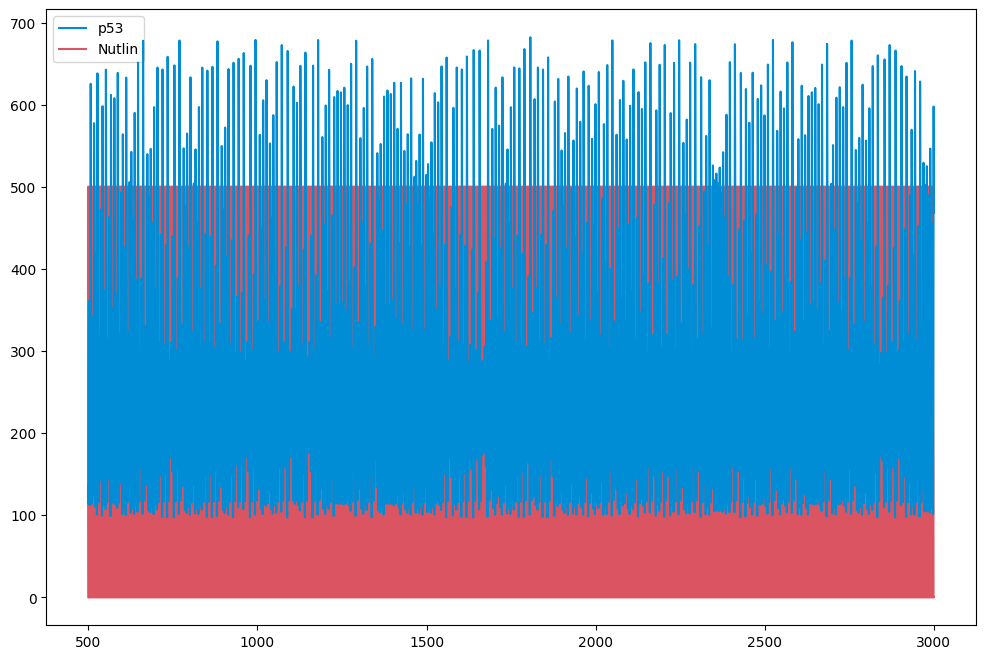

In [118]:
plt.figure(figsize=(12,8))
plt.plot(all_t[transient_window:], all_p[transient_window:], color=colors["p53"], zorder=10, label="p53")
plt.plot(all_t[transient_window:], all_n[transient_window:], color=colors["nutlin"], label="Nutlin")

plt.legend()
plt.plot()

[]

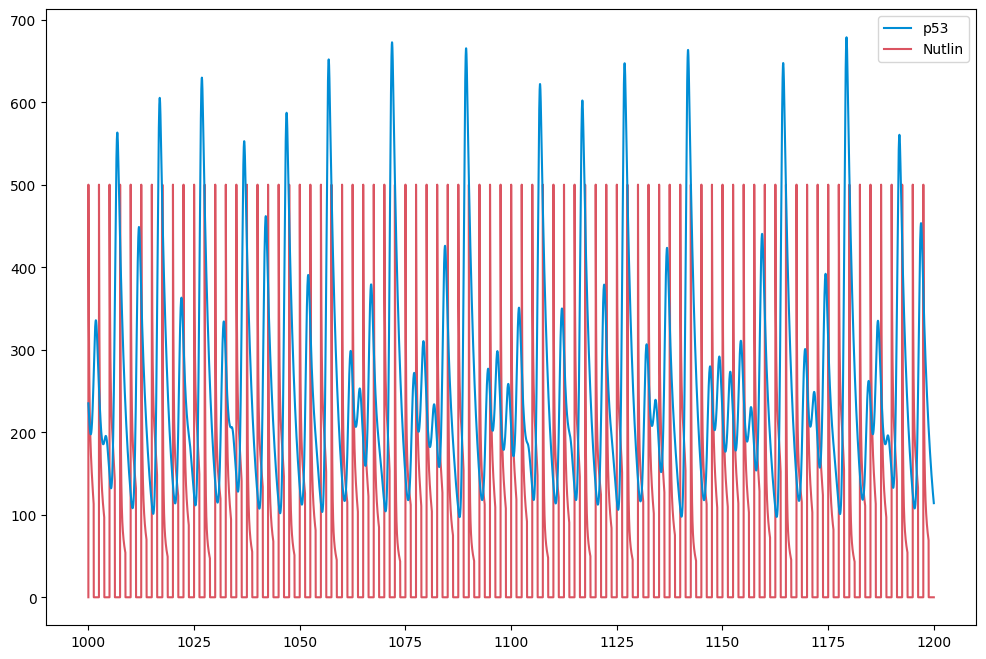

In [119]:
plt.figure(figsize=(12,8))
plt.plot(all_t[100000:120000], all_p[100000:120000], color=colors["p53"], zorder=10, label="p53")
plt.plot(all_t[100000:120000], all_n[100000:120000], color=colors["nutlin"], label="Nutlin")

plt.legend()
plt.plot()

Text(0.5, 0.92, 'Simulating the p53 network')

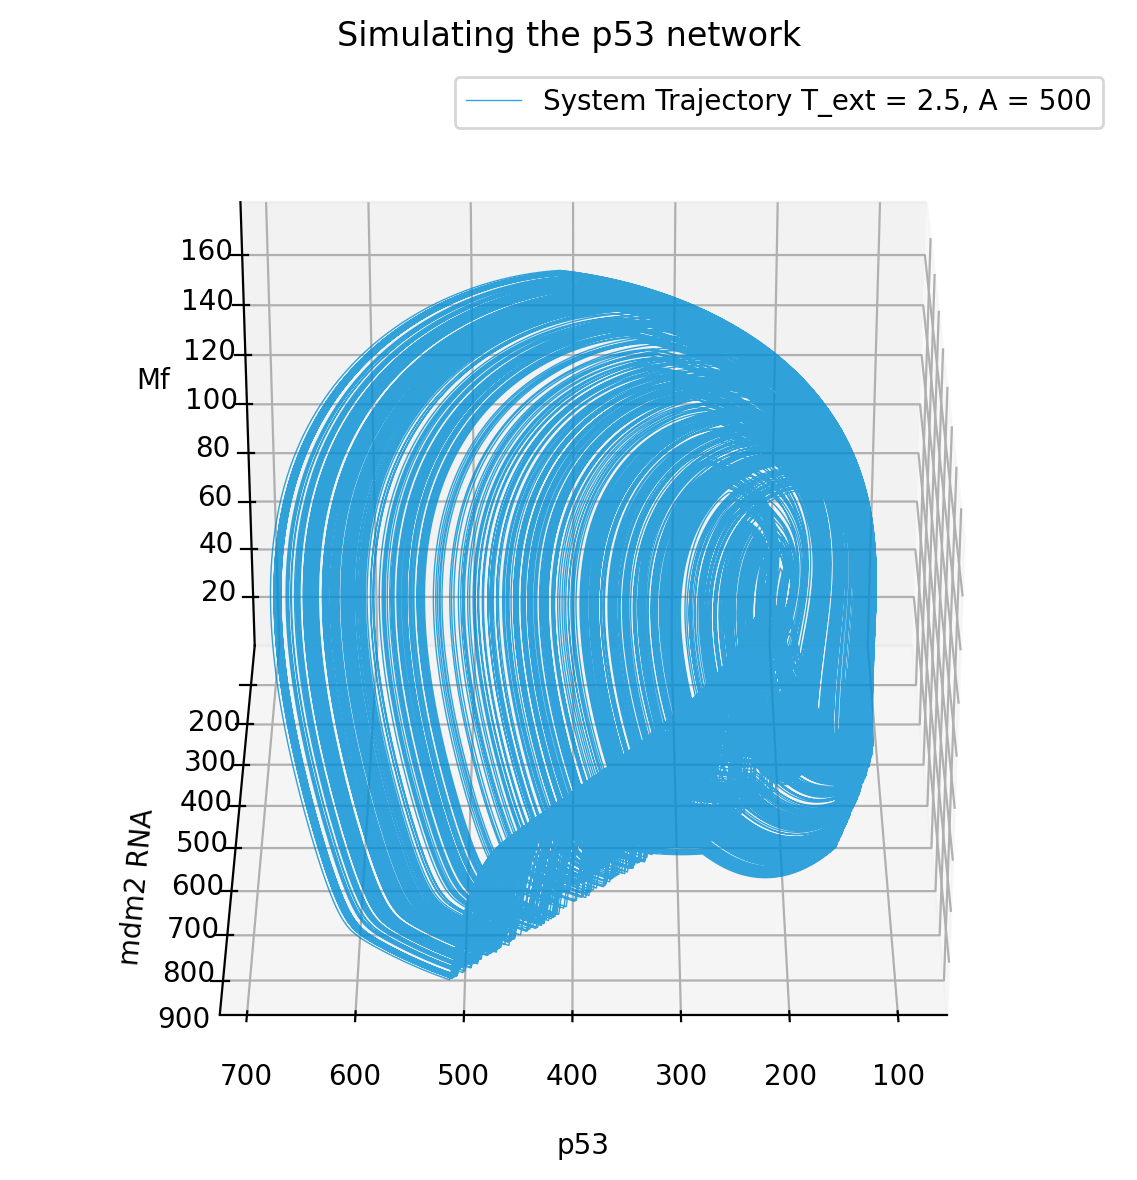

In [120]:
fig = plt.figure(figsize=(6, 6), dpi=200)
ax_3d = fig.add_subplot(111, projection='3d')  # Correct index for 3D plot
ax_3d.plot(all_p[transient_window:], all_m[transient_window:], all_Mf[transient_window:], color=colors["p53"], alpha=0.8, lw=0.5, label=f'System Trajectory T_ext = {2 * half_period_nutlin}, A = {nutlin_amplitude}')
ax_3d.set_xlabel(r'p53', labelpad=10)
ax_3d.set_ylabel('mdm2 RNA', labelpad=10)
ax_3d.set_zlabel('Mf', labelpad=10)

# Adjusting the view angle
ax_3d.view_init(elev=30, azim=90)  # Adjust elevation and azimuth to improve visibility

ax_3d.set_title(f'3D Phase Space')
ax_3d.legend()


plt.tight_layout()
plt.title("Simulating the p53 network")

In [ ]:
for i in range(36):
    fig = plt.figure(figsize=(6, 6), dpi=120)
    ax_3d = fig.add_subplot(111, projection='3d')  # Correct index for 3D plot
    ax_3d.plot(all_p[100000:], all_m[100000:], all_Mf[100000:], color=colors["p53"], alpha=0.8, lw=0.5, label=f'System Trajectory T_ext = {2 * half_period_nutlin}, A = {nutlin_amplitude}')
    ax_3d.set_xlabel(r'p53', labelpad=10)
    ax_3d.set_ylabel('mdm2 RNA', labelpad=10)
    ax_3d.set_zlabel('Mf', labelpad=10)

    # Adjusting the view angle
    ax_3d.view_init(elev=5*i, azim=i * 10)  # Adjust elevation and azimuth to improve visibility

    ax_3d.set_title(f'3D Phase Space')
    ax_3d.legend()


    plt.tight_layout()
    plt.title("Simulating the p53 network")

# Spread on the attractor

In [127]:
trajectories = 1

In [128]:
all_final = []

for i in tqdm(range(trajectories)):
    # Generating a vector with length 1e-13 in a random direction
    v = np.random.rand(3)
    v_hat = (v / np.linalg.norm(v)) * 1e-12

    p0_d = p0.copy()
    p0_d[0:3] = p0_d[0:3]+ v_hat
    
    x_i = odeRungeKutta4_p53(f_p53, x0 = p0_d, dt = ddt, simT = total_t, tstart_nut = nutlin_begin_t, tend_nut = nutlin_end_t,
                       t_ON = half_period_nutlin, t_OFF = half_period_nutlin, nut_const = nutlin_amplitude, args = (kc1,kc2,kc3,kc4,kc5,kc6,kc7,kc8,kc9))

    all_p_i = x_i[:, 0]
    all_m_i = x_i[:, 1]
    all_Mf_i = x_i[:, 2]
    all_n_i = x_i[:, -1]

    all_final.append([all_p_i, all_m_i, all_Mf_i, all_n_i])

100%|██████████| 1/1 [00:04<00:00,  4.55s/it]


In [129]:
all_final = np.array(all_final)

p_all = all_final[:, 0]
m_all = all_final[:, 1]
Mf_all = all_final[:, 2]
n_all = all_final[:, -1]

In [130]:
p_last = [current[-1] for current in p_all]
m_last = [current[-1] for current in m_all]
Mf_last = [current[-1] for current in Mf_all]

Text(0.5, 0.92, 'Strange Attractor for p53')

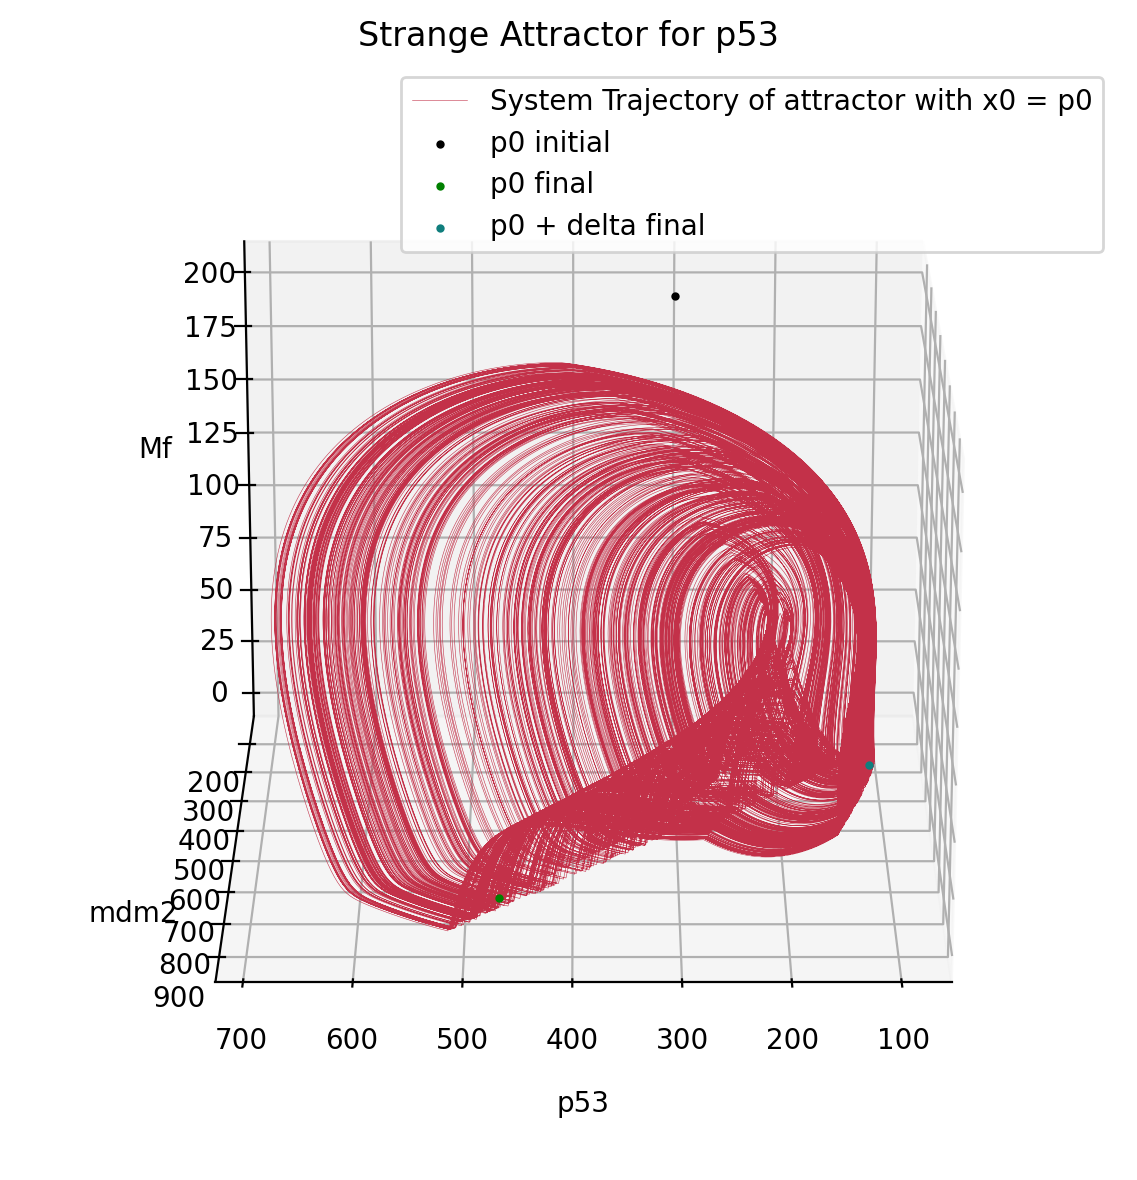

In [134]:
fig = plt.figure(figsize=(6, 6), dpi=200)
ax_3d = fig.add_subplot(111, projection='3d')  # Correct index for 3D plot
ax_3d.plot(all_p[transient_window:], all_m[transient_window:], all_Mf[transient_window:], color=colors["nfkb"], lw=0.2, label=f'System Trajectory of attractor with x0 = p0')
ax_3d.scatter(all_p[0], all_m[0], all_Mf[0], color="black", s=4, zorder=10, label=f'p0 initial')
ax_3d.scatter(all_p[-1], all_m[-1], all_Mf[-1], color="green", s=4, zorder=10, label=f'p0 final')
ax_3d.scatter(p_last, m_last, Mf_last, color=colors["tnf"], s=4, label=f'p0 + delta final')
ax_3d.set_xlabel(r'p53', labelpad=10)
ax_3d.set_ylabel('mdm2', labelpad=10)
ax_3d.set_zlabel(f'Mf', labelpad=10)
ax_3d.view_init(elev=20, azim=90) 

ax_3d.set_title(f'3D Phase Space')
ax_3d.legend()


plt.tight_layout()
plt.title("Strange Attractor for p53")

In [ ]:
for i in range(len(p_all)):
    plt.figure(figsize=(12,8))
    plt.plot(all_t[transient_window:], p_all[i][transient_window:], color=colors["p53"], zorder=10, label="p53")
    plt.plot(all_t[transient_window:], n_all[i][transient_window:], color=colors["nutlin"], label="Nutlin")

    plt.legend()
    plt.plot()

# Lyapunov

In [156]:
x = odeRungeKutta4_p53(f_p53, x0 = p0, dt = ddt, simT = total_t, tstart_nut = nutlin_begin_t, tend_nut = nutlin_end_t,
                       t_ON = half_period_nutlin, t_OFF = half_period_nutlin, nut_const = nutlin_amplitude, args = (kc1,kc2,kc3,kc4,kc5,kc6,kc7,kc8,kc9))
# Generating a vector with length 1e-13 in a random direction
v = np.random.rand(3)
v_hat = (v / np.linalg.norm(v)) * 1e-12

p0_d = p0.copy()
p0_d[0:3] = p0_d[0:3]+ v_hat
x_delta = odeRungeKutta4_p53(f_p53, x0 = p0_d, dt = ddt, simT = total_t, tstart_nut = nutlin_begin_t, tend_nut = nutlin_end_t,
                       t_ON = half_period_nutlin, t_OFF = half_period_nutlin, nut_const = nutlin_amplitude, args = (kc1,kc2,kc3,kc4,kc5,kc6,kc7,kc8,kc9))
t_0 = np.arange(0, total_t, 0.01)
p_0 = x[:, 0]
m_0 = x[:, 1]
Mf_0 = x[:, 2]
n_0 = x[:, -1]

t_delta = np.arange(0, total_t, 0.01)
p_delta = x_delta[:, 0]
m_delta = x_delta[:, 1]
Mf_delta = x_delta[:, 2]
n_delta = x_delta[:, -1]

In [203]:
p0_delta_v = np.stack((p_delta[transient_window:], m_delta[transient_window:], Mf_delta[transient_window:]), axis=1)
p0_v = np.stack((p_0[transient_window:], t_0[transient_window:], Mf_0[transient_window:]), axis=1)

In [204]:
delta = p0_v - p0_delta_v

In [205]:
sliced_time = all_t[transient_window:]

In [206]:
norms = []

for diff_i in delta:
    norms.append(np.linalg.norm(diff_i))

In [207]:
norms = np.log(np.array(norms))

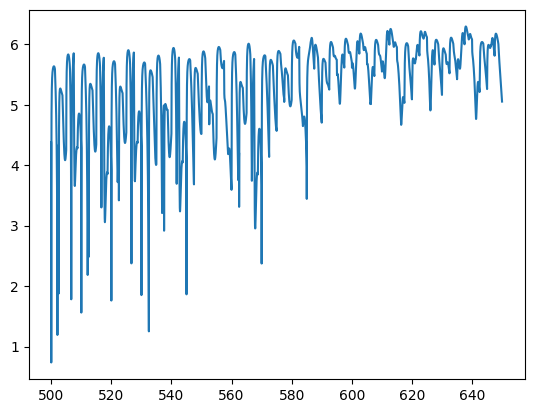

In [208]:
plt.plot(sliced_time[:15000], norms[:15000])

In [209]:
def lin_fit(x, a, b):
    return x*a + b

In [210]:
par, cov = curve_fit(lin_fit, sliced_time[:15000], norms[:15000], sigma = np.ones(len(sliced_time[:15000])) * 1e-12, absolute_sigma=True)

In [211]:
a, b = par

In [212]:
yss = lin_fit(sliced_time[:15000], *par)

In [213]:
da, db = np.sqrt(np.diag(cov))

In [214]:
print(a, "+/-", da)

0.008739519046574877 +/- 1.8856180741920173e-16


Text(0.5, 1.0, 'Estimation of Liapunov Exponent of chaotic p53 configuration')

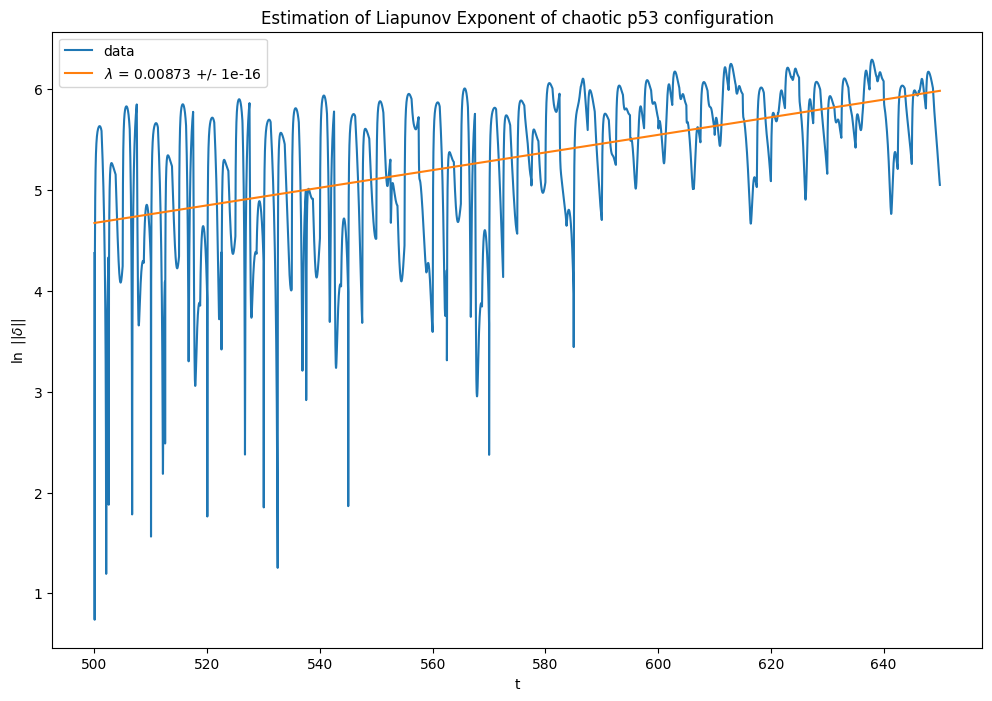

In [217]:
plt.figure(figsize=(12,8))

plt.plot(sliced_time[:15000], norms[:15000], label="data")
plt.plot(sliced_time[:15000], yss, label=r"$\lambda$ = 0.00873 +/- 1e-16")

plt.legend()
plt.xlabel("t")
plt.ylabel(r"$\ln\ ||\delta|| $")
plt.title("Estimation of Liapunov Exponent of chaotic p53 configuration")